In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from time import time
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


# Download necessary NLTK packages
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Extraction Features

In [46]:
df = pd.read_csv("../PreProcessing/processed_data/Resume_proc_lemm.csv")

In [47]:
# Get a list of stop word
stop_words = set(nltk.corpus.stopwords.words('english'))

In [48]:
tfidf_vect = TfidfVectorizer(
    lowercase=True,
    binary=False,
    max_features=10000,
    stop_words=list(stop_words),   # come prima, valuta se serve
    ngram_range=(1, 6),            # unigrams fino a 6-grams
    max_df=0.8,
    min_df=2
)

In [49]:
def extract_features(X_train, X_test):
    
    X_train_tfidf = tfidf_vect.fit_transform(X_train)
    X_test_tfidf = tfidf_vect.transform(X_test)

    return X_train_tfidf, X_test_tfidf

In [50]:
def smote(X_train, y_train):
    #print("Distribuzione delle classi nel training set prima di SMOTE:")
    # print(y_train.value_counts())
    
    # Identifica le classi minoritarie
    class_counts = y_train.value_counts()
    min_classes = class_counts[class_counts < 0.7*class_counts.mean()].index.tolist()
    
    print(f"Applicazione di SMOTE alle classi: {min_classes} \n")
    
    # Crea un dizionario per la strategia di campionamento
    target_size = int(class_counts.max() * 0.8)
    sampling_strategy = {cls: target_size for cls in min_classes}
    
    # Applica SMOTE
    smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    # print("Distribuzione delle classi nel training set dopo SMOTE:")
    # print(pd.Series(y_train_resampled).value_counts())
    
    return X_train_resampled, y_train_resampled

In [51]:
# Split data into training and validation
X_train, X_test, y_train, y_test = train_test_split(df['Resume_str'], df['Category'], test_size=0.2, random_state=42, stratify=df['Category'])


# Print the sizes of the split datasets
print("Train data size:", X_train.shape)
print("Validation data size:", X_test.shape)

Train data size: (1986,)
Validation data size: (497,)


In [52]:
X_train_features, X_test_features = extract_features(X_train, X_test)

In [53]:
X_train_resampled, y_train_resampled = smote(X_train_features, y_train)

Applicazione di SMOTE alle classi: ['AGRICULTURE', 'AUTOMOBILE', 'BPO'] 



In [54]:
len(tfidf_vect.vocabulary_)

10000

### Support Vector Classifier

In [55]:
def report(results, n_top=10):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results["rank_test_score"] == i)
        for candidate in candidates:
            print(f"Model with rank: {i}")
            print(f"Mean validation score: {results['mean_test_score'][candidate]:.3f} (std: {results['std_test_score'][candidate]:.3f})")
            print(f"Parameters: {results['params'][candidate]}")
            print("")

In [56]:
skf = StratifiedKFold(n_splits=5)

In [57]:
# Pipeline: TF-IDF + Scaling + SVM
svm_pipeline = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),  # with_mean=False per sparse matrix
    ('clf', SVC())
])

param_grid_svm = [
    {
        'clf__kernel': ['linear'],
        'clf__C': [0.1, 1, 10, 100]
    },
    {
        'clf__kernel': ['poly'],
        'clf__C': [1, 10],
        'clf__degree': [2, 3],
        'clf__coef0': [0.5, 1.0]
    }
]

grid_svm = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=param_grid_svm,
    cv=skf,
    scoring='accuracy',
    verbose=3,
    n_jobs=-1
)


In [58]:
#'''
start = time()
grid_search_svm = grid_svm.fit(X_train_resampled, y_train_resampled)
print(f"GridSearchCV took {(time() - start):.2f} seconds for {len(grid_search_svm.cv_results_['params'])} candidates parameter settings.\n")

report(grid_search_svm.cv_results_)
print(grid_search_svm.best_params_)
#'''

Fitting 5 folds for each of 12 candidates, totalling 60 fits
GridSearchCV took 401.92 seconds for 12 candidates parameter settings.

Model with rank: 1
Mean validation score: 0.662 (std: 0.016)
Parameters: {'clf__C': 1, 'clf__coef0': 1.0, 'clf__degree': 2, 'clf__kernel': 'poly'}

Model with rank: 1
Mean validation score: 0.662 (std: 0.016)
Parameters: {'clf__C': 10, 'clf__coef0': 1.0, 'clf__degree': 2, 'clf__kernel': 'poly'}

Model with rank: 3
Mean validation score: 0.660 (std: 0.013)
Parameters: {'clf__C': 0.1, 'clf__kernel': 'linear'}

Model with rank: 3
Mean validation score: 0.660 (std: 0.013)
Parameters: {'clf__C': 1, 'clf__kernel': 'linear'}

Model with rank: 3
Mean validation score: 0.660 (std: 0.013)
Parameters: {'clf__C': 10, 'clf__kernel': 'linear'}

Model with rank: 3
Mean validation score: 0.660 (std: 0.013)
Parameters: {'clf__C': 100, 'clf__kernel': 'linear'}

Model with rank: 7
Mean validation score: 0.658 (std: 0.016)
Parameters: {'clf__C': 10, 'clf__coef0': 0.5, 'clf__

In [59]:
print(grid_search_svm.best_params_)

{'clf__C': 1, 'clf__coef0': 1.0, 'clf__degree': 2, 'clf__kernel': 'poly'}


In [60]:
'''
# Estrai i risultati di GridSearchCV per SVM
results_svm = pd.DataFrame(grid_search_svm.cv_results_)

# Filtra i risultati in base ai parametri di interesse (ad esempio, kernel 'linear' vs 'rbf')
filtered_svm = results_svm[
    (results_svm['param_kernel'] == 'rbf')  # o 'linear' a seconda di cosa vuoi visualizzare
]

# Pivot table per visualizzare la "mean_test_score" in funzione di C e gamma
pvt_svm = filtered_svm.pivot_table(
    values='mean_test_score',
    index='param_C',
    columns='param_gamma'
)

# Crea la heatmap
f, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(pvt_svm, cmap='viridis', annot=True, ax=ax)
plt.title('SVM Accuracy (kernel=rbf)')
plt.xlabel('gamma')
plt.ylabel('C')
plt.show()

'''

'\n# Estrai i risultati di GridSearchCV per SVM\nresults_svm = pd.DataFrame(grid_search_svm.cv_results_)\n\n# Filtra i risultati in base ai parametri di interesse (ad esempio, kernel \'linear\' vs \'rbf\')\nfiltered_svm = results_svm[\n    (results_svm[\'param_kernel\'] == \'rbf\')  # o \'linear\' a seconda di cosa vuoi visualizzare\n]\n\n# Pivot table per visualizzare la "mean_test_score" in funzione di C e gamma\npvt_svm = filtered_svm.pivot_table(\n    values=\'mean_test_score\',\n    index=\'param_C\',\n    columns=\'param_gamma\'\n)\n\n# Crea la heatmap\nf, ax = plt.subplots(figsize=(6, 5))\nsns.heatmap(pvt_svm, cmap=\'viridis\', annot=True, ax=ax)\nplt.title(\'SVM Accuracy (kernel=rbf)\')\nplt.xlabel(\'gamma\')\nplt.ylabel(\'C\')\nplt.show()\n\n'

In [61]:

SVC_Model_best = grid_search_svm.best_estimator_
prediction = SVC_Model_best.predict(X_test_features)

In [62]:
# SVC_Model_best = SVC(random_state=42, max_features='sqrt', n_estimators= 700, max_depth=10, criterion='gini')
# SVC_Model_best.fit(X_train_resampled, y_train_resampled)

In [63]:
# prediction = SVC_Model_best.predict(X_test_features)

In [64]:
print("Training Score: {:.2f}".format(SVC_Model_best.score(X_train_resampled, y_train_resampled)))
print("Test Score: {:.2f}".format(SVC_Model_best.score(X_test_features, y_test)))

Training Score: 1.00
Test Score: 0.63


In [65]:

print(classification_report(y_test, prediction))

                        precision    recall  f1-score   support

            ACCOUNTANT       0.69      0.83      0.75        24
              ADVOCATE       0.36      0.54      0.43        24
           AGRICULTURE       0.64      0.54      0.58        13
               APPAREL       0.40      0.32      0.35        19
                  ARTS       0.50      0.48      0.49        21
            AUTOMOBILE       1.00      0.29      0.44         7
              AVIATION       0.78      0.58      0.67        24
               BANKING       0.62      0.70      0.65        23
                   BPO       0.00      0.00      0.00         4
  BUSINESS-DEVELOPMENT       0.57      0.83      0.68        24
                  CHEF       0.83      0.62      0.71        24
          CONSTRUCTION       0.70      0.64      0.67        22
            CONSULTANT       0.40      0.35      0.37        23
              DESIGNER       0.84      0.76      0.80        21
         DIGITAL-MEDIA       0.77      

c:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

<Figure size 1500x1000 with 0 Axes>

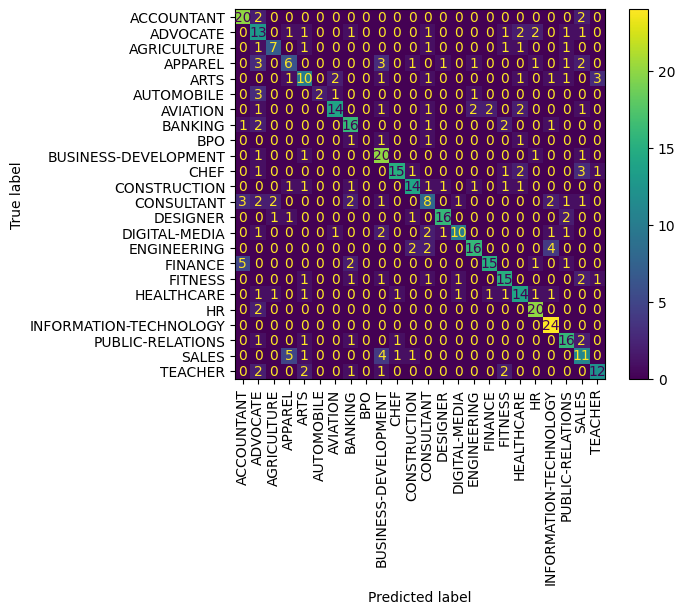

In [66]:
plt.figure(figsize=(15, 10))  # Imposta la dimensione della figura
ConfusionMatrixDisplay.from_predictions(y_test, prediction)
plt.xticks(rotation=90)
plt.show()